#### Tools For Modern Macroeconometrics

## Term paper - 1st stage

##### Summer semester 2022/23

*Author:* Petr Čala
___
### *Environment preparation, package handling, and file validation:*

In [399]:
##### ENVIRONMENT PREPARATION #####

# Clean the environment
rm(list = ls()) 

#Plot display options
options(warn=-1, repr.plot.width = 12, repr.plot.height = 6, xts.warn_dplyr_breaks_lag=FALSE, scipen=999)

set.seed(420)

##### STATIC #####

# Required packages
packages <- c(
  "pdfetch", # Downloading data
  "forecast", # autoplot function, ARIMA
  "xts", # plot.xts function
  "urca", # Unit root test
  "seasonal", # Seasonal adjustments
  "stats", # Autocorr fun, spectrum, periodogram
  "mFilter", # HP filter
  "neverhpfilter", # Hamilton's regression filter
  "tsbox",
  "strucchange", # Structural breaks in data
  "quantmod", # Period-over-period changes ("periodReturn")
  "TSA", # periodogram
  "statcheck", # Structural breaks
  "tseries" # Tests
)
# Other useful packages - "dplyr", "quantmod", "moments", "StableEstim", "stabledist", "tseries")

##### PREPARATION #####

# Load the source script
if (!file.exists("cala_termpaper_source.R")){
  print('Please make sure to put the source file \"cala_termpaper_source\" in
        your working directory.')
  stop("Source file failed to load.")
} else{
  source("cala_termpaper_source.R")
  print("Source file loaded.")
}

# Load packages
loadPackages(packages)


[1] "Source file loaded."
[1] "All packages loaded successfully"


### *Obtaining the data*:

We fetch the data using the *fetch* function form the `pdfetch` package. We will use the widest range of time possible, and with this, fetch the data for GDP and Consumer Price Index.

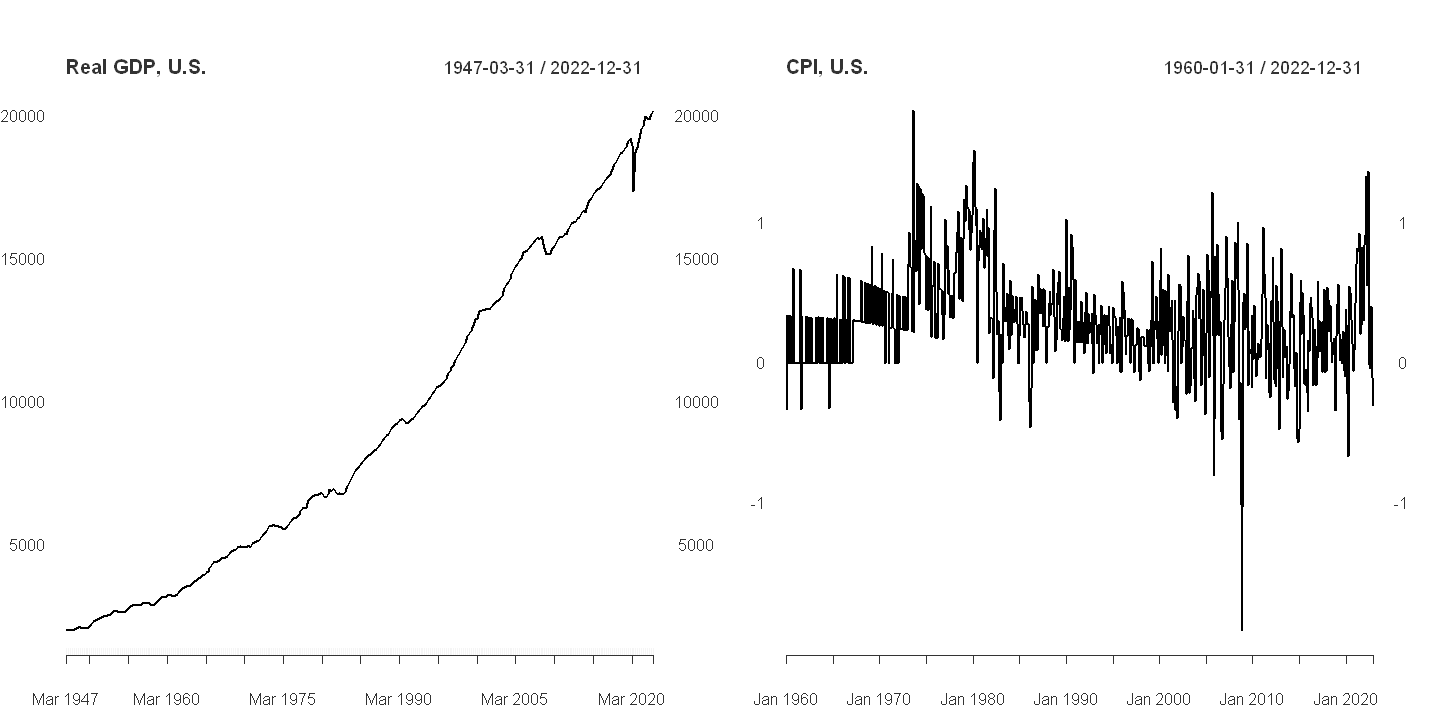

In [400]:
# Set the static variables
us_gdp_id <- "GDPC1"
us_cpi_id <- "CPALTT01USM657N"
start_date <- 2020
end_date <- 2023

# Retrieve the U.S. GDP and consumer price index data using "pdfetch_FRED"
us_gdp_data <- pdfetch_FRED(us_gdp_id)
us_cpi_data <- pdfetch_FRED(us_cpi_id)

# Plot the original time series using 'plot.xts'
par(mfrow=c(1,2))
plot.xts(us_gdp_data, main="Real GDP, U.S.", grid.col=NA, yaxis.left=TRUE)
plot.xts(us_cpi_data, main="CPI, U.S.", grid.col=NA, yaxis.left=TRUE)


### *Data transformation*:

We transform the data according to the instructions. Most comments are provided inside the code block, but we would just like to mention, that the `seas` function did not work for us, thus we decided to go with the `decompose` function for seasonal trend extraction instead.

Also, the CPI data comes in the log form as is, so there is no need to transform it, as it had already been done for us by the data provider.

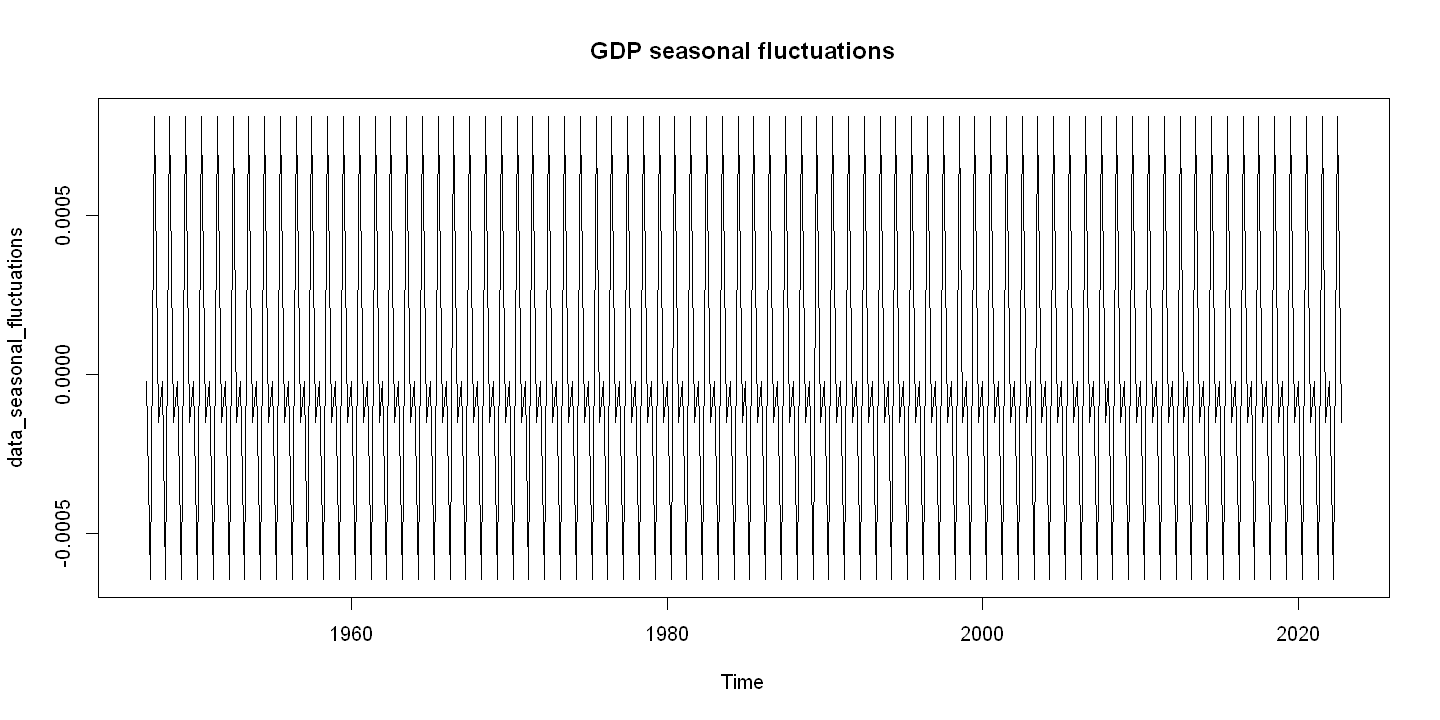

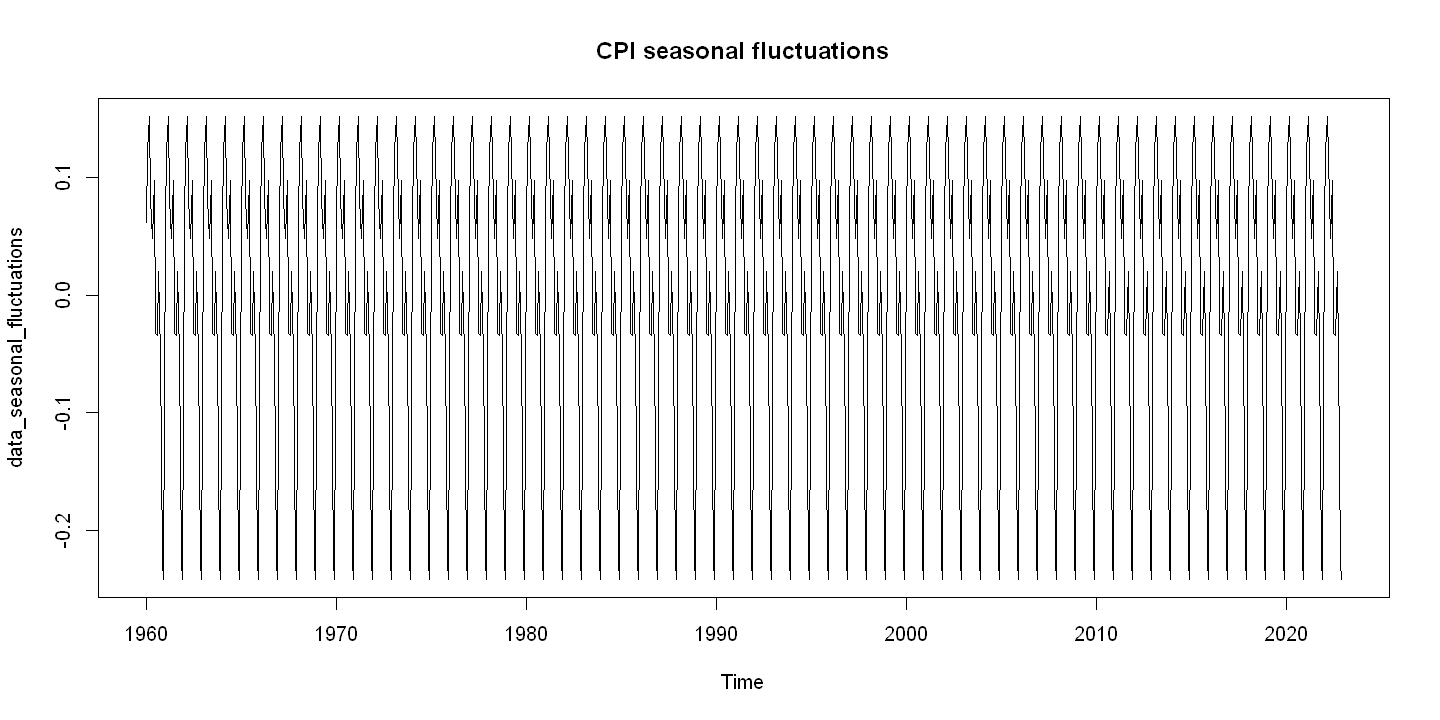

In [416]:
### 1.
gdp_quarterly <- handleSeasonality(log(us_gdp_data), "GDP")
cpi_quarterly <- handleSeasonality(us_cpi_data, "CPI")

Indeed it looks like a yearly seasonality was present in the unadjusted data, so extracting this, we should have clean data, which we will use from now on.

After extracting the seasonal components from the CPI, we can take a look at the Y-O-Y, M-O-M, and P-O-P changes. For GDP, we can not do the M-O-M, because we do not have the data. With CPI, there arise several missing and infinite values when computing the percentage change, so we simply remove these, for simplicity. Otherwise, we make good use of a custom function, which allows us to directly compute the percentage changes, while defining the number of periods to look back during the computation.

In [426]:
us_cpi_data

           CPALTT01USM657N
1960-01-31      -0.3401361
1960-02-29       0.3412969
1960-03-31       0.0000000
1960-04-30       0.3401361
1960-05-31       0.0000000
1960-06-30       0.3389831
1960-07-31       0.0000000
1960-08-31       0.0000000
1960-09-30       0.0000000
1960-10-31       0.6756757
       ...                
2022-03-31      1.33513795
2022-04-30      0.55825310
2022-05-31      1.10235240
2022-06-30      1.37360758
2022-07-31     -0.01181191
2022-08-31     -0.03543993
2022-09-30      0.21507845
2022-10-31      0.40564944
2022-11-30     -0.10100264
2022-12-31     -0.30700915

In [417]:
### 3. 
print('Transforming data...')
# Transform the series back into xts for easier handling
gdp_dates <- index(us_gdp_data)
gdp_source <- xts(gdp_quarterly, order.by = gdp_dates) # Quarterly GDP
colnames(gdp_source) <- "GDP"

cpi_dates <- index(us_cpi_data) # Use original dates
cpi_source <- xts(cpi_monthly, order.by = cpi_dates) # Monthly CPI
colnames(cpi_source) <- "CPI"

## Period-over-period percentage changes
gdp_pop_change <- getPercentageChanges(gdp_source, "P-O-P GDP returns", look_back = 1) # Quarterly returns
cpi_pop_change <- getPercentageChanges(cpi_source, "P-O-P CPI returns", look_back = 1) # Monthly returns

# ## Calculate month-to-month changes
# # Impossible for GDP due to lack of data
cpi_mom_change <- cpi_pop_change

# ## Year-over-year percentage changes
gdp_yoy_change <- getPercentageChanges(gdp_source, "Y-O-Y GDP returns", look_back = 4)
cpi_yoy_change <- getPercentageChanges(cpi_source, "Y-O-Y CPI returns", look_back = 12)

print('Data transformation complete.')



[1] "Transforming data..."
[1] "Data transformation complete."


### *Structural validation*:

With these data, we can take a look at any potential remaining seasonal effects in the m-o-m series, check for structural breaks, stationarity, and other characteristics.

[1] "Running structural checks for monthly CPI"
[1] "Running the augmented Dickey-Fuller test for monthly CPI..."

	Augmented Dickey-Fuller Test

data:  time_series
Dickey-Fuller = -18.331, Lag order = 1, p-value = 0.01
alternative hypothesis: stationary

[1] "The m-o-m transformed series is stationary and has zero order of integration"
[1] "Running structural checks for quarterly GDP"
[1] "Running the augmented Dickey-Fuller test for quarterly GDP..."

	Augmented Dickey-Fuller Test

data:  time_series
Dickey-Fuller = -10.268, Lag order = 1, p-value = 0.01
alternative hypothesis: stationary

[1] "The m-o-m transformed series is stationary and has zero order of integration"


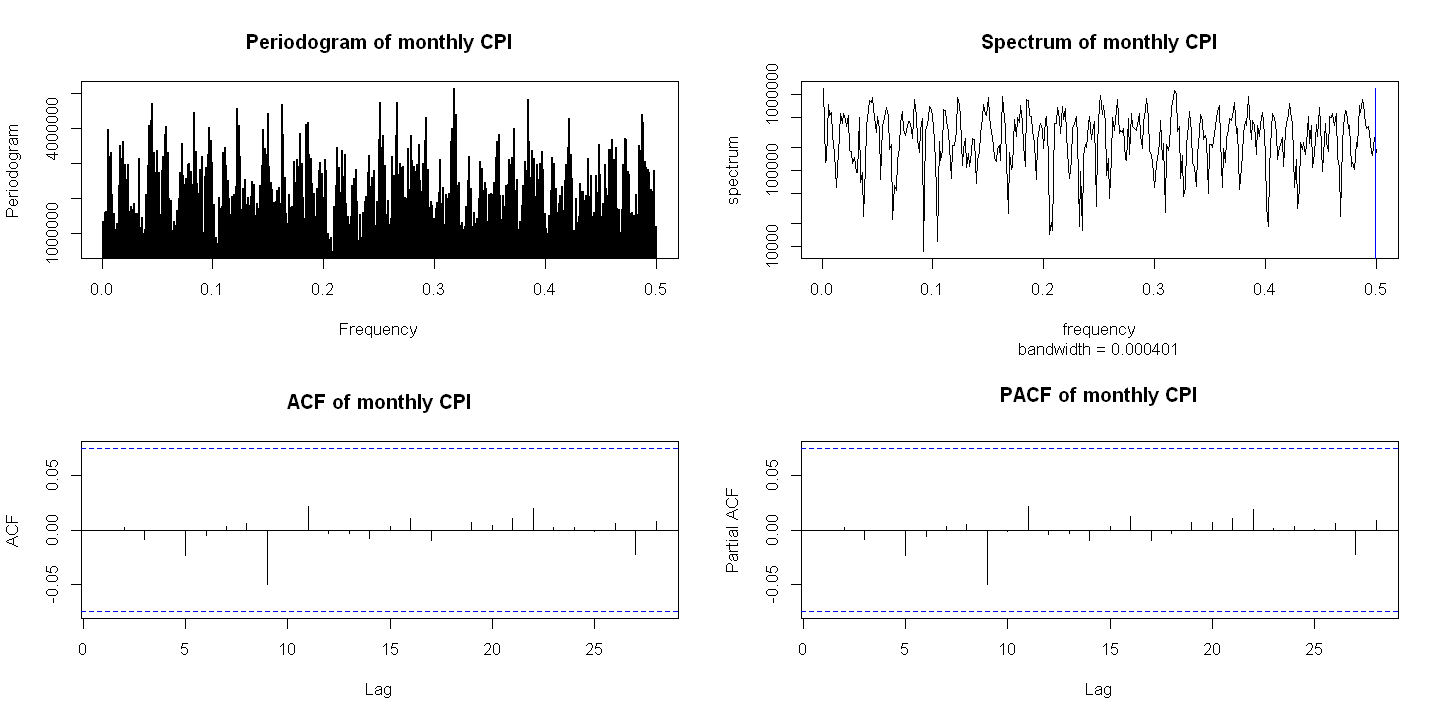

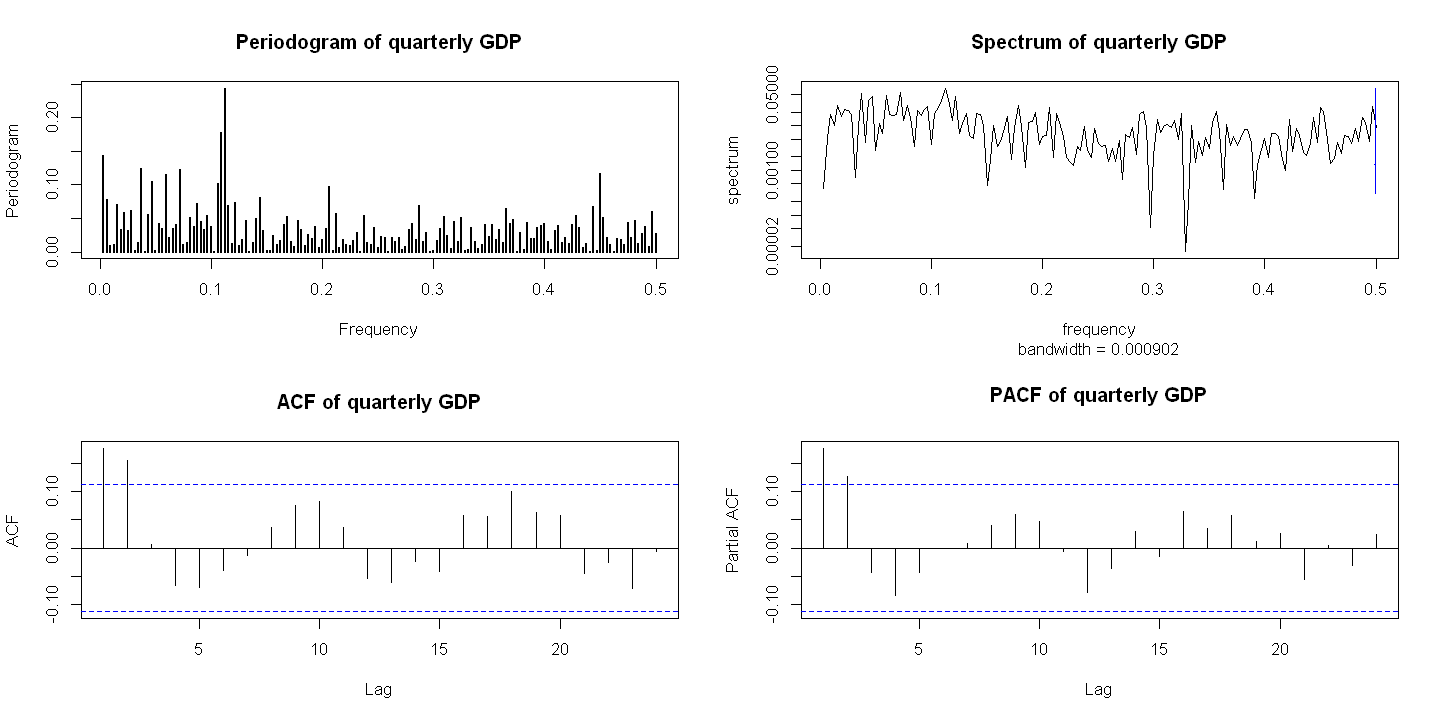

In [420]:
# Run various structural checks using a compact function (for details see the source R script)
par(mfrow=c(2,2))
runStructuralChecks(cpi_mom_change, "monthly CPI")
runStructuralChecks(gdp_pop_change, "quarterly GDP")

On previous results


### *Linear Model Estimation*:

Now we will try to estimate several linear models, to see which fit the two series the best. Both of the series should be stationary, so linear models should work just fine in our case. We will model on the monthly data, which allow for the largest granularity. We will run the specification check models on data of other granularity at the end.

The ACF and PACF plots for either series suggest a simple model should suffice, say *ARMA(2,0)* in the case of GDP, and *ARMA(1,0)* in the case of CPI. We will first see what model the `auto.arima` function suggests, to get an idea, and then go on to



In [423]:
auto.arima(gdp_pop_change)
auto.arima(cpi_mom_change)

Series: gdp_pop_change 
ARIMA(3,1,2) 

Coefficients:
         ar1     ar2      ar3      ma1     ma2
      0.8868  0.0188  -0.1659  -1.7336  0.7394
s.e.  0.2232  0.0836   0.0573   0.2224  0.2194

sigma^2 = 0.01628:  log likelihood = 194.2
AIC=-376.41   AICc=-376.12   BIC=-354.14

Series: cpi_mom_change 
ARIMA(0,0,0) with zero mean 

sigma^2 = 1240138:  log likelihood = -5718.46
AIC=11438.92   AICc=11438.92   BIC=11443.44

`auto.arima` suggest *ARIMA(3,1,2)* for the GPD, and *ARIMA(0,0,0)* for CPI. We suppose that the integration of order 1 suggested for GDP may arise from the variability in frequencies of the data, but otherwise the data appears stationary, so we do not think it necessary to include the integration order. As for the CPI, we will have to delve a bit deeper.

To get an idea of which orders might be good to model, we resort to an iterative function `getBoxLjung`, which will create 36 basic ARIMA models, and return the values of their Ljung-Box test, ran on their residuals, understandably. We will then search for a **tradeoff between the number of orders and the large p-value from the test**, as the simpler models are usually the best.

In [425]:
# Get the data frame of p-values from the B-L test
print('Monthly GDP Ljung-Box test p-values for different orders of ARIMA')
getBoxLjung(gdp_pop_change)

print('Monthly CPI Ljung-Box test p-values for different orders of ARIMA')
getBoxLjung(cpi_mom_change)

[1] "Monthly GDP Ljung-Box test p-values for different orders of ARIMA"


AR order,MA order,4 lags,8 lags,12 lags
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0.001080977,0.007821383,0.01063557
0,1,0.076760458,0.257118266,0.29644656
0,2,0.884902762,0.959090748,0.86572032
0,3,0.944395901,0.982146069,0.89428127
0,4,0.999518357,0.992715939,0.92977223
1,0,0.161724288,0.432463112,0.46753974
1,1,0.373991890,0.639565428,0.59135004
1,2,0.921638769,0.973876672,0.88096584
1,3,0.973835077,0.985865404,0.90387238


[1] "Monthly CPI Ljung-Box test p-values for different orders of ARIMA"


AR order,MA order,4 lags,8 lags,12 lags
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0.9996426,0.9998758,0.9979810
0,1,0.9996461,0.9998761,0.9979834
0,2,0.9997071,0.9998802,0.9979686
0,3,1.0000000,0.9999185,0.9981248
0,4,1.0000000,0.9999184,0.9981233
1,0,0.9996461,0.9998761,0.9979834
1,1,0.9996461,0.9998761,0.9979834
1,2,0.9997072,0.9998802,0.9979686
1,3,1.0000000,0.9999185,0.9981248


Looking at the tables, for GDP, we can see potential candidates in ARMAs (3,1), (0,2), or maybe (1,2). As for CPI, (0,4) seems to be, quite surprisingly, the most interesting option. The ACF functions of both of these would suggest to include at least some AR lags, so for GDP, I would like to explore *ARMA(3,1)*, but for CPI, the *ARMA(0,4)* just appears to make the most sense, given the Ljung-Box test results alone. 

Let's get to modelling, then.


Call:
arima(x = gdp_mom_change, order = c(3, 0, 1))

Coefficients:
         ar1     ar2      ar3      ma1  intercept
      0.7243  0.0516  -0.1395  -0.5649     0.0868
s.e.  0.2775  0.0833   0.0602   0.2757     0.0087

sigma^2 estimated as 0.01608:  log likelihood = 195.73,  aic = -381.45


	Box-Ljung test

data:  GDP_ARMA$residuals
X-squared = 0.81532, df = 4, p-value = 0.9364



	Box-Ljung test

data:  GDP_ARMA$residuals
X-squared = 1.1282, df = 8, p-value = 0.9973



	Box-Ljung test

data:  GDP_ARMA$residuals
X-squared = 5.1707, df = 12, p-value = 0.952


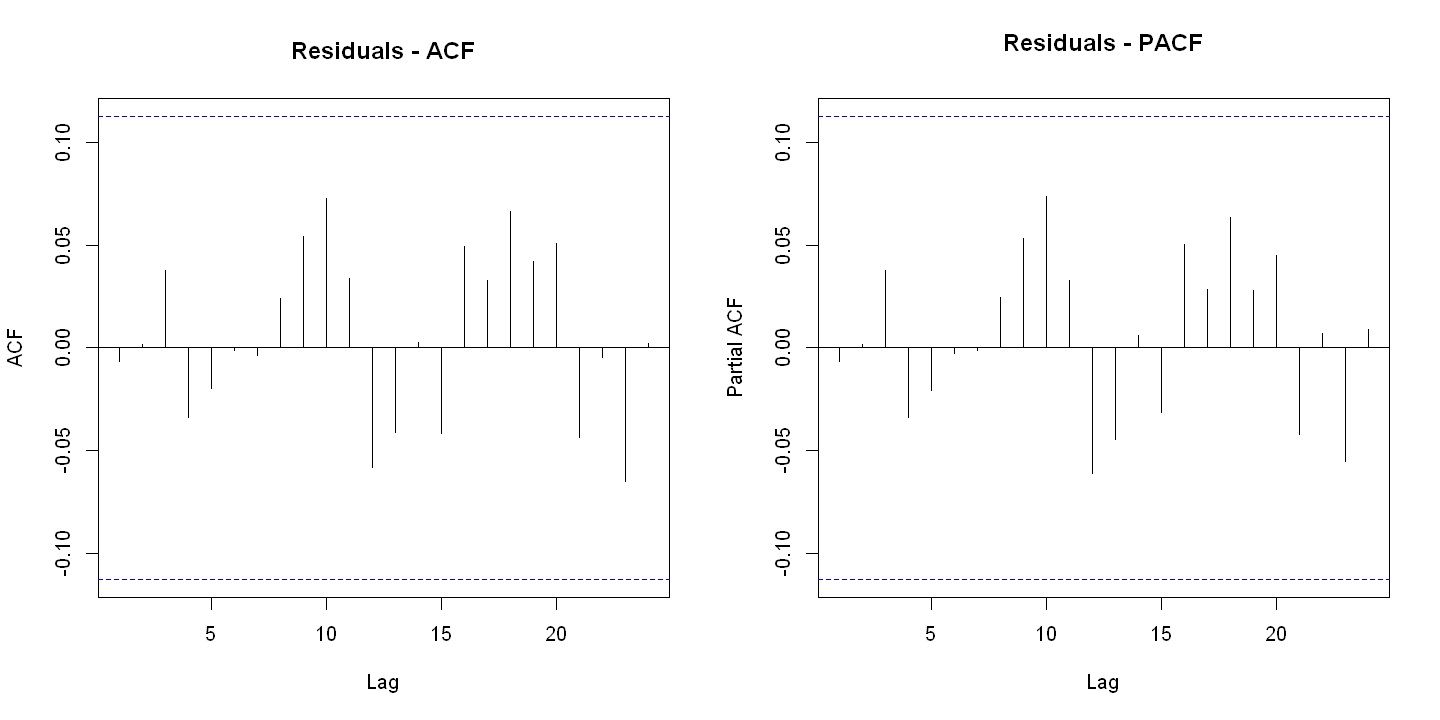

In [235]:
### 4.

## GDP ARMA modelling
GDP_ARMA <- arima(gdp_mom_change, order = c(3, 0, 1))
GDP_ARMA

par(mfrow = c(1, 2))
acf(GDP_ARMA$residuals, main = 'Residuals - ACF')
pacf(GDP_ARMA$residuals, main = 'Residuals - PACF')

Box.test(GDP_ARMA$residuals, type = "Ljung-Box", lag = 4)
Box.test(GDP_ARMA$residuals, type = "Ljung-Box", lag = 8)
Box.test(GDP_ARMA$residuals, type = "Ljung-Box", lag = 12)


Call:
arima(x = cpi_mom_change, order = c(0, 0, 4))

Coefficients:
          ma1      ma2     ma3      ma4  intercept
      -0.2844  -0.1236  0.0447  -0.1046    -0.4886
s.e.   0.0448   0.0472  0.0482   0.0451     1.8078

sigma^2 estimated as 5747:  log likelihood = -2879.4,  aic = 5768.8


	Box-Ljung test

data:  CPI_ARMA$residuals
X-squared = 0.43217, df = 4, p-value = 0.9798



	Box-Ljung test

data:  CPI_ARMA$residuals
X-squared = 6.4564, df = 8, p-value = 0.5962



	Box-Ljung test

data:  CPI_ARMA$residuals
X-squared = 11.476, df = 12, p-value = 0.4886


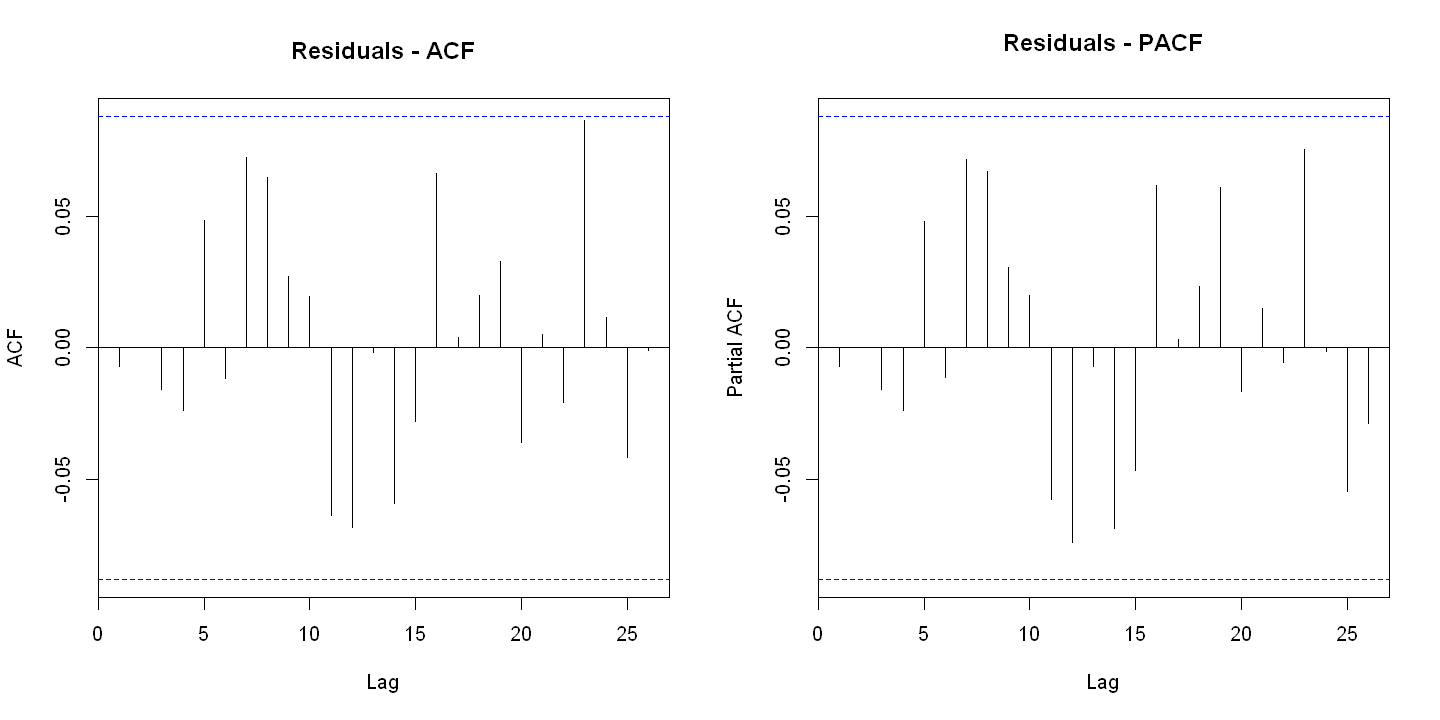

In [239]:
## CPI ARMA modelling
CPI_ARMA <- arima(cpi_mom_change, order = c(0, 0, 4))
CPI_ARMA

par(mfrow = c(1, 2))
acf(CPI_ARMA$residuals, main = 'Residuals - ACF')
pacf(CPI_ARMA$residuals, main = 'Residuals - PACF')

Box.test(CPI_ARMA$residuals, type = "Ljung-Box", lag = 4)
Box.test(CPI_ARMA$residuals, type = "Ljung-Box", lag = 8)
Box.test(CPI_ARMA$residuals, type = "Ljung-Box", lag = 12)


Given we ran the Ljung-Box tests ahead of time, it is no surprise that the **residuals are well behaved**. Most of the leading coefficients are statistically significant too, which is good.

Let's try forecasting with these models.

             M-O-M GPD
1947-06-30 -0.03506298
1947-09-30 -0.02714857
1947-12-31  0.20366979
1948-03-31  0.19551532
1948-06-30  0.21396120
1948-09-30  0.07455317
1948-12-31  0.01456364
1949-03-31 -0.18114049
1949-06-30 -0.04465692
1949-09-30  0.13418246
       ...            
2020-09-30  0.77149896
2020-12-31  0.09738539
2021-03-31  0.15534038
2021-06-30  0.17145615
2021-09-30  0.06622490
2021-12-31  0.16992541
2022-03-31 -0.04152627
2022-06-30 -0.01462160
2022-09-30  0.08058420
2022-12-31  0.06661937

In [245]:
## Forecasting with the two ARMA models
new_ts <- ts(gdp_mom_change, frequency=12)
# gdp_window <- window(gdp_mom_change, end = c(2024, 4))
# cpi_window <- window(cpi_mom_change, end = c(2024, 4))


ERROR: Error in .toPOSIXct(end, tzone(x)): invalid time / time based class




### *Estimating the Output Gap*:

Intro here

In [ ]:
### 5.

#Code here

Results of the output gap estimation here

##